In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, Dense,Input,Layer
from keras import backend as K,Model
from numpy.random import seed
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.preprocessing import StandardScaler
seed(0)
import os
os.environ['PYTHONHASHSEED']=str(0)
from sklearn.metrics import roc_curve,roc_auc_score
import tensorflow as tf
tf.random.set_seed(0)
import random
import random as python_random
python_random.seed(0)
random.seed(0)

In [89]:
from scipy.io.arff import loadarff 
from sklearn.preprocessing import LabelEncoder

raw_data = loadarff('base_desenv_02.arff')
data = pd.DataFrame(raw_data[0])
data.rename(columns={'flag_fraude_cat': 'Class'}, inplace=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Label encode the 'Class' column
data['Class'] = label_encoder.fit_transform(data['Class'])
tr_data = data
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']
y=tr_data['Class']
X_train=X
y_train=y

In [90]:
raw_data = loadarff('base_validacao_02.arff')
data = pd.DataFrame(raw_data[0])
data.rename(columns={'flag_fraude_cat': 'Class'}, inplace=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Label encode the 'Class' column
data['Class'] = label_encoder.fit_transform(data['Class'])
tr_data = data
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']
y=tr_data['Class']
X_test=X
y_test=y

In [91]:
SZ=StandardScaler()
X_train=pd.DataFrame(SZ.fit_transform(X_train))
X_test=pd.DataFrame(SZ.transform(X_test))

from sklearn.linear_model import SGDOneClassSVM
df1_normal=X_train[y_train==0]
clf = SGDOneClassSVM(nu=0.02,random_state=0)
res = clf.fit_predict(df1_normal)
res[res==1] = 0
res[res==-1] = 1
ros = RandomUnderSampler(sampling_strategy=0.95)
ros.fit_resample(df1_normal,res)
index=ros.sample_indices_
X_train.drop(X_train.index[index], inplace=True)
y_train.drop(y_train.index[index], inplace=True)

In [92]:
X_train.shape

(28704, 17)

In [93]:
X_test.shape

(12543, 17)

In [94]:
# X_train et X_test sont des dataframe qui contient les features
train_LSTM_X=X_train.to_numpy()
test_LSTM_X=X_test.to_numpy()
train_LSTM_y=y_train.to_numpy()
test_LSTM_y=y_test.to_numpy()
w=3
X_train=np.zeros([train_LSTM_X.shape[0]-w+1,w, train_LSTM_X.shape[1]])
for i in range(train_LSTM_X.shape[0]-w+1):
    for j in range(w):
        X_train[i][j]=train_LSTM_X[i+j]
X_test=np.zeros([test_LSTM_X.shape[0]-w+1,w, test_LSTM_X.shape[1]])
for i in range(test_LSTM_X.shape[0]-w+1):
    for j in range(w):
        X_test[i][j]=test_LSTM_X[i+j]
## Recuperation des labels

y_train=np.delete(train_LSTM_y,[*range(0, w-1, 1)], 0)
y_test=np.delete(test_LSTM_y,[*range(0, w-1, 1)], 0)


In [105]:
inputs=Input((w,17))
x1=LSTM(50)(inputs)
outputs=Dense(1,activation='sigmoid')(x1)
model=Model(inputs,outputs)

In [106]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

In [107]:
history1=model.fit(X_train, y_train,epochs=100,batch_size=256,validation_data=(X_test,y_test))

Epoch 1/100
113/113 [==============================] - 5s 15ms/step - loss: 0.3082 - precision: 0.1081 - recall: 0.1454 - val_loss: 0.1320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
113/113 [==============================] - 1s 8ms/step - loss: 0.1221 - precision: 0.4000 - recall: 0.0019 - val_loss: 0.1220 - val_precision: 0.8333 - val_recall: 0.0107
Epoch 3/100
113/113 [==============================] - 1s 8ms/step - loss: 0.1142 - precision: 0.5769 - recall: 0.0278 - val_loss: 0.1172 - val_precision: 0.5526 - val_recall: 0.0450
Epoch 4/100
113/113 [==============================] - 1s 9ms/step - loss: 0.1100 - precision: 0.6000 - recall: 0.0722 - val_loss: 0.1141 - val_precision: 0.5294 - val_recall: 0.0771
Epoch 5/100
113/113 [==============================] - 1s 8ms/step - loss: 0.1078 - precision: 0.5953 - recall: 0.1185 - val_loss: 0.1128 - val_precision: 0.5733 - val_recall: 0.0921
Epoch 6/100
113/113 [==============================] - 1s 8ms/step - loss: 0

In [108]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# reduce to 1d array
yhat_probs =  yhat_probs[:, 0]> 0.5
yhat_probs=yhat_probs.astype(int)

In [109]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_probs)
print('Recall: %f' % recall)
f1 = f1_score(y_test, yhat_probs)
print('f1: %f' % f1)
auc_score=roc_auc_score(y_test, yhat_probs)
print('auc_score: %f' % auc_score)

Accuracy: 0.961566
Precision: 0.476923
Recall: 0.331906
f1: 0.391414
auc_score: 0.658913


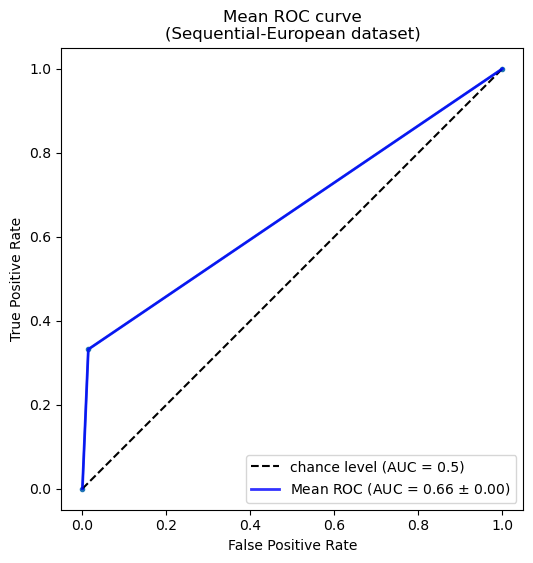

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, yhat_probs, pos_label=1)
auc_score=roc_auc_score(y_test, yhat_probs)
plt.figure(figsize=(6,6)) 

plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = tpr
mean_auc = auc(fpr, mean_tpr)
std_auc = np.std(auc_score)
plt.plot(
    fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Mean ROC curve\n(Sequential-European dataset)")
plt.axis("square")
plt.legend(loc="lower right")

plt.show()


In [111]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [112]:
cm = confusion_matrix(y_true=y_test, y_pred=yhat_probs)

In [113]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[11904   170]
 [  312   155]]


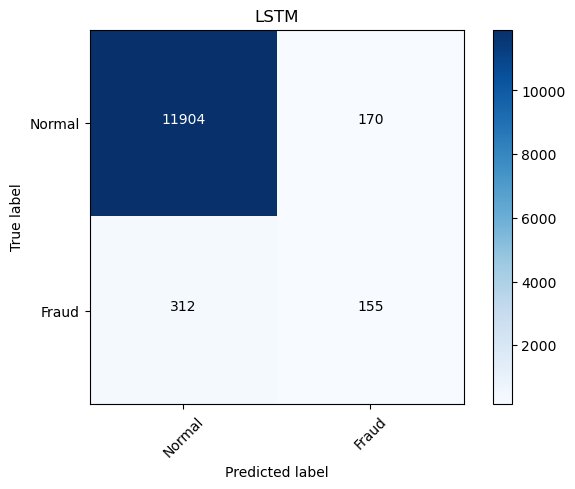

In [114]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')